In [1]:
import os
# tensorflow version
import tensorflow

# keras version
import keras

from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [4]:
%cd 'ELEC 576/'

/content/gdrive/MyDrive/ELEC 576


In [5]:
%ls

descriptions.pkl    Flickr8k_Dataset/  ixtoword.pkl
encoding_test.pkl   Flickr8k_text/     saved_model/
encoding_train.pkl  glove/             wordtoix_dict.pkl


In [6]:
from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [7]:
import string
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time
import nltk
from nltk.translate import bleu_score
from nltk.tokenize import word_tokenize
!pip install TensorFlowTTS
!pip install git+"https://github.com/repodiac/german_transliterate.git#egg=german_transliterate"
import numpy as np
import soundfile as sf
import yaml

import tensorflow as tf

from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

# 1. Loading the Dataset:

In [8]:
!pwd

/content/gdrive/MyDrive/ELEC 576


In [9]:
token_path = "Flickr8k_text/Flickr8k.token.txt"
train_images_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr8k_text/Flickr_8k.testImages.txt'
images_path = './Flickr8k_Dataset/'
glove_path = './glove/'
doc = open(token_path,'r').read()
print(doc[:410])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cab


#### Creating a descriptions list 

#### Create a dictionary with the names of the images as keys along with the 5 captions for the image as captions

In [10]:
descriptions = dict()
for line in doc.split('\n'):
  tokens = line.split()
  if len(line) > 2:
    image_id = tokens[0].split('.')[0]
    image_desc = ' '.join(tokens[1:])
    if image_id not in descriptions:
        descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

#### Convert descriptions to lowercase and remove punctuation 

In [11]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

#### Saving the descriptions as pickle file for later use.

In [12]:
import pickle
with open('descriptions.pkl','wb') as f:
    pickle.dump(descriptions, f)

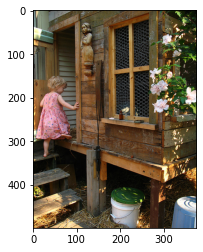

['child in a pink dress is climbing up a set of stairs in an entry way ',
 'girl going into a wooden building ',
 'little girl climbing into a wooden playhouse ',
 'little girl climbing the stairs to her playhouse ',
 'little girl in a pink dress going into a wooden cabin ']

In [13]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

#### Create a vocabulary of unique words present across all the images in the data set

In [14]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

# Here we get 8828 unique words in the 40000 image captions

Original Vocabulary Size: 8745


#### Save the image id's and the cleaned captions

In [15]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

#### Load the images from dataset to the train variable

In [16]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

####  save training images to train_img
####  save testing images to test_img

In [17]:

img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

#### Load the descriptions into a dictionary
#### Add to tokens to every caption i.e ‘startseq’ and ‘endseq’

In [18]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)



#### Make a list of all the training captions

In [19]:

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

#### Reduce the vocabulary to only the words that occur atleast n times

In [20]:
word_count_threshold = 3
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1638


#### create two dicts to map 1. words to an index 2. index to words

In [21]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [22]:
import pickle
with open("ixtoword.pkl","wb") as f:
    pickle.dump(ixtoword,f)

#### Find the max length of caption

In [23]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

Description Length: 37


#### map all the words in our 38-word long caption to a 200-dimension vector using Glove

In [24]:

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

####   make matrix of shape (1660,200) 

In [25]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Load the inceptionV3 model

In [26]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 0s 0us/step


#### We remove the softmax layer from the model as we are not classfying but rather extracting image vector for our images

In [27]:
model_new = Model(model.input, model.layers[-2].output)

#### Reshape images to 299 x 299

In [28]:
from tensorflow.keras.utils import load_img, img_to_array

In [29]:
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

### encode training and testing images

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

#### 1. Sequence is processed from the text
#### 2. Image is used to extract feature vector
#### 3. Concatenate the above two layers and decode output using softmax


In [72]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 37)]         0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 37, 200)      327800      ['input_19[0][0]']               
                                                                                                  
 dropout_57 (Dropout)           (None, 2048)         0           ['input_18[0][0]']               
                                                                                            

### make the weights in the embedding layer not trainable

In [75]:

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

### Compile the model using Categorical_Crossentropy Loss function and Adam optimizer

In [76]:

model.compile(loss='categorical_crossentropy', optimizer='adam')

### Function to train data in batches

In [77]:


def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

### train model for 30 epochs.

In [83]:

epochs = 30
batch_size = 64
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
93/93 [==============================] - 25s 271ms/step - loss: 2.8122
Epoch 2/30
93/93 [==============================] - 24s 258ms/step - loss: 2.7927
Epoch 3/30
93/93 [==============================] - 24s 253ms/step - loss: 2.7745
Epoch 4/30
93/93 [==============================] - 26s 281ms/step - loss: 2.7607
Epoch 5/30
93/93 [==============================] - 24s 254ms/step - loss: 2.7459
Epoch 6/30
93/93 [==============================] - 24s 259ms/step - loss: 2.7339
Epoch 7/30
93/93 [==============================] - 24s 258ms/step - loss: 2.7201
Epoch 8/30
93/93 [==============================] - 23s 252ms/step - loss: 2.7074
Epoch 9/30
93/93 [==============================] - 24s 255ms/step - loss: 2.6946
Epoch 10/30
93/93 [==============================] - 24s 258ms/step - loss: 2.6831
Epoch 11/30
93/93 [==============================] - 24s 258ms/step - loss: 2.6684
Epoch 12/30
93/93 [==============================] - 24s 255ms/step - loss: 2.6557
Epoch 13/30
9

### A vector generated by the model is greedily picked to find the next word prediction.

In [84]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

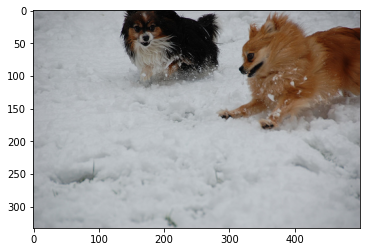

Greedy Search: dog is running through the snow


In [85]:

pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

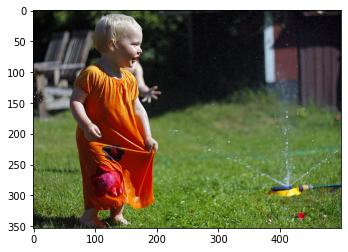

Greedy Search: little girl in a pink dress is playing with a ball


In [86]:
pic = '3767841911_6678052eb6.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

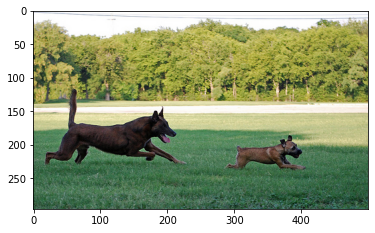

Greedy Search: brown dog is running through the grass


In [87]:
pic = '2723477522_d89f5ac62b.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

#### Find the top k predictions and refeed into model then sort based on the probablities returened by model. We repeat till we reach 'endseq' or the max length

In [44]:

def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp_predicted_data
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

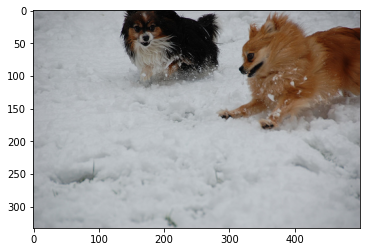

Greedy Search: dog is running through the snow
Beam Search, K = 3: black and white dog runs through the snow
Beam Search, K = 5: black and white dog runs through the snow
Beam Search, K = 7: black and white dog runs through the snow
Beam Search, K = 10: black and white dog runs through the snow


In [45]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

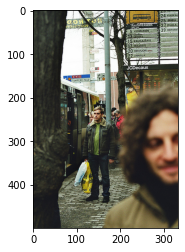

Greedy Search: man in a black shirt is standing by a man in a black shirt and a woman in a black shirt and a woman in a white shirt and a woman in a white shirt and
Beam Search, K = 3: man in a white shirt is standing by a bus
Beam Search, K = 5: group of people stand outside of a bus
Beam Search, K = 7: group of people sitting on a bench in front of a crowd
Beam Search, K = 10: group of people sitting on a bench in front of a crowd


In [46]:
pic = '3344233740_c010378da7.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

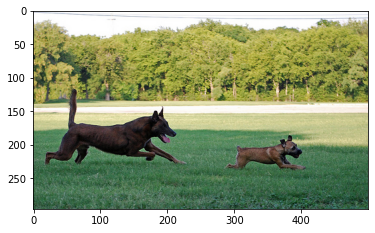

Greedy Search: brown and white dog is running through a grassy field
Beam Search, K = 5: brown and white dog is playing with a soccer ball in the grass
Beam Search, K = 20: brown and white dog plays with a soccer ball in the grass
Beam Search, K = 50: closeup of a brown dog trying to catch a tennis ball in a grassy field
Beam Search, K = 100: closeup of a brown dog trying to catch a soccer ball


In [47]:
pic = '2723477522_d89f5ac62b.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
# print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))
print("Beam Search, K = 20:",beam_search_predictions(image, beam_index = 20))
print("Beam Search, K = 50:",beam_search_predictions(image, beam_index = 50))
print("Beam Search, K = 100:",beam_search_predictions(image, beam_index = 100))

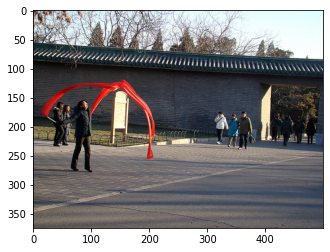

Greedy Search: man is performing a trick on a skateboard
Beam Search, K = 3: man is performing a trick on a skateboard
Beam Search, K = 5: group of people are standing in front of a white building
Beam Search, K = 7: group of people are watching a skateboarder on a skate park
Beam Search, K = 10: group of people doing a trick on a city street


In [88]:
pic_name = '3207358897_bfa61fa3c6'
pic = f'{pic_name}.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
temp_true_data = descriptions[pic_name]
temp_predicted_data = [greedySearch(image),beam_search_predictions(image, beam_index = 3),beam_search_predictions(image, beam_index = 5),beam_search_predictions(image, beam_index = 7),beam_search_predictions(image, beam_index = 10)]
print("Greedy Search:",temp_predicted_data[0])
print("Beam Search, K = 3:",temp_predicted_data[1])
print("Beam Search, K = 5:",temp_predicted_data[2])
print("Beam Search, K = 7:",temp_predicted_data[3])
print("Beam Search, K = 10:",temp_predicted_data[4])


In [49]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [89]:
temp_true_data = [word_tokenize(i) for i in temp_true_data]
print(temp_true_data)
temp_predicted_data = [word_tokenize(i) for i in temp_predicted_data]
print(temp_predicted_data)
s1 = []
for pred in temp_predicted_data:
    s1.append(bleu_score.sentence_bleu(temp_true_data,pred))
s2= bleu_score.corpus_bleu(temp_true_data, temp_predicted_data)
print(s1)
print(s2)

[['asian', 'girl', 'performs', 'a', 'routine', 'with', 'two', 'red', 'flags', 'in', 'a', 'square'], ['person', 'waving', 'long', 'red', 'flags'], ['woman', 'plays', 'with', 'long', 'red', 'ribbons', 'in', 'an', 'empty', 'square'], ['waving', 'two', 'long', 'red', 'streamers', 'around'], ['people', 'work', 'with', 'long', 'ribbons', 'in', 'a', 'chinese', 'courtyard']]
[['man', 'is', 'performing', 'a', 'trick', 'on', 'a', 'skateboard'], ['man', 'is', 'performing', 'a', 'trick', 'on', 'a', 'skateboard'], ['group', 'of', 'people', 'are', 'standing', 'in', 'front', 'of', 'a', 'white', 'building'], ['group', 'of', 'people', 'are', 'watching', 'a', 'skateboarder', 'on', 'a', 'skate', 'park'], ['group', 'of', 'people', 'doing', 'a', 'trick', 'on', 'a', 'city', 'street']]
[1.1368587676511996e-231, 1.1368587676511996e-231, 1.3165594234639305e-231, 1.3165594234639305e-231, 1.3483065280626046e-231]
1.0832677820940877e-231


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

### BLEU score calculation

In [90]:
s1 = []
sf = bleu_score.SmoothingFunction()
for pred in temp_predicted_data:
    s1.append(bleu_score.sentence_bleu(temp_true_data,pred,smoothing_function=sf.method3,weights=(0.99, 0.00, 0.00, 0.00)))
s2= bleu_score.corpus_bleu(temp_true_data, temp_predicted_data,smoothing_function=sf.method3)
print([' '.join(i) for i in temp_true_data])
print(list(zip([' '.join(i) for i in temp_predicted_data],s1)))
print(s2)

['asian girl performs a routine with two red flags in a square', 'person waving long red flags', 'woman plays with long red ribbons in an empty square', 'waving two long red streamers around', 'people work with long ribbons in a chinese courtyard']
[('man is performing a trick on a skateboard', 0.22370402506524714), ('man is performing a trick on a skateboard', 0.22370402506524714), ('group of people are standing in front of a white building', 0.27629389183815767), ('group of people are watching a skateboarder on a skate park', 0.27629389183815767), ('group of people doing a trick on a city street', 0.30363374919493424)]
0.013795613281826095


In [92]:
!pip install TensorFlowTTS
!pip install git+"https://github.com/repodiac/german_transliterate.git#egg=german_transliterate"
import numpy as np
import soundfile as sf
import yaml

import tensorflow as tf

from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

# initialize fastspeech2 model.
fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en")


# initialize mb_melgan model
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-ljspeech-en")


# inference
processor = AutoProcessor.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en")

input_ids = processor.text_to_sequence("We will use tensorflow but we plan to expand and train this model further")
# fastspeech inference

mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
)

# melgan inference
audio_before = mb_melgan.inference(mel_before)[0, :, 0]
audio_after = mb_melgan.inference(mel_after)[0, :, 0]

# save to file
sf.write('./audio_before.wav', audio_before, 22050, "PCM_16")
sf.write('./audio_after.wav', audio_after, 22050, "PCM_16")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/repodiac/german_transliterate.git to /tmp/pip-install-bqm9879e/german-transliterate_293fa1be5787408f9f3a77c3d04a41f8
  Running command git clone -q https://github.com/repodiac/german_transliterate.git /tmp/pip-install-bqm9879e/german-transliterate_293fa1be5787408f9f3a77c3d04a41f8
